In [26]:
hierarchy_level_delimiter = '_'

# Non-Negative MinTrace

Large collections of time series organized into structures at different aggregation levels often require their forecasts to follow their aggregation constraints and to be nonnegative, which poses the challenge of creating novel algorithms capable of coherent forecasts.

The `HierarchicalForecast` package provides a wide collection of Python implementations of hierarchical forecasting algorithms that follow nonnegative hierarchical reconciliation.

In this notebook, we will show how to use the `HierarchicalForecast` package to perform nonnegative reconciliation of forecasts on `Wiki2` dataset.

You can run these experiments using CPU or GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/NonNegativeReconciliation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%%capture
!pip install hierarchicalforecast statsforecast datasetsforecast

## 1. Load Data

In this example we will use the `Wiki2` dataset. The following cell gets the time series for the different levels in the hierarchy, the summing dataframe  `S_df` which recovers the full dataset from the bottom level hierarchy and the indices of each hierarchy denoted by `tags`.

In [28]:
import numpy as np
import pandas as pd

from datasetsforecast.hierarchical import HierarchicalData

In [29]:
Y_df, S_df, tags = HierarchicalData.load('./data', 'Wiki2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [30]:
Y_df.head()

,unique_id,ds,y
0,Total,2016-01-01,156508
1,Total,2016-01-02,129902
2,Total,2016-01-03,138203
3,Total,2016-01-04,115017
4,Total,2016-01-05,126042


<font color='blue'>This is a representation of the Hierarchy - 1 means that column name (item, Drugs in our case), belongs to the Total row. Rows represent totals at each level of the hierarchy, for each node</font>

In [31]:
S_df.iloc[:5, :5]

,de_AAC_AAG_001,de_AAC_AAG_010,de_AAC_AAG_014,de_AAC_AAG_045,de_AAC_AAG_063
Total,1,1,1,1,1
de,1,1,1,1,1
en,0,0,0,0,0
fr,0,0,0,0,0
ja,0,0,0,0,0


<font color='blue'>Ariel: Replace ` - ` with `_`. I think `_` is used as Hierarchy level split by HF package (not sure)</font>

In [32]:
df = pd.read_excel('data/Quarterly_smoothing.xlsx')#.iloc[:,:5]#, index_col=0)

df.columns = df.columns.str.replace(' - ', hierarchy_level_delimiter)

save_shape = df.shape
#df = df.loc[:, (df != 0).all()]

#print("Removed", save_shape[1] - df.shape[1], "Columns with at least one 0 in them")
# adding 1 unit everywhere
for c in df.columns[1:]:
  df[c] = df[c]+1
df.head()

,Month,Дальневосточный ФО_ADRIANOL_Adrianol for adults nasal drops 10 ml #1,Дальневосточный ФО_AGALATES_Agalates tabs 0.5 mg #2,Дальневосточный ФО_AGALATES_Agalates tabs 0.5 mg #8,Дальневосточный ФО_ALMAGEL_Almagel A susp 170 ml #1,Дальневосточный ФО_ALMAGEL_Almagel Neo sachet 10 ml #10,Дальневосточный ФО_ALMAGEL_Almagel Neo susp 170 ml #1,Дальневосточный ФО_ALMAGEL_Almagel sachet 10 ml #10,Дальневосточный ФО_ALMAGEL_Almagel susp 170 ml #1,Дальневосточный ФО_ALMONT_Almont FC tabs 10 mg #28,...,Южный ФО_VELBINE_Velbine solution for inf 10 mg/ml 5ml #1,Южный ФО_VESTIBO_Vestibo tabs 16 mg #30,Южный ФО_VESTIBO_Vestibo tabs 24 mg #30,Южный ФО_VINCRISTINE-TEVA_Vincristine-Teva lyoph for inf 1 mg/ml 1 ml #1,Южный ФО_VINCRISTINE-TEVA_Vincristine-Teva lyoph for inf 1 mg/ml 2 ml #1,Южный ФО_VINORELBINE-TEVA_VINORELBIN-TEVA 50 mg.5 ml,Южный ФО_VINORELBINE-TEVA_VINORELBINE-TEVA concentrate 10 mg.ml 1 ml,Южный ФО_ZINCTERAL_Zincteral-Teva FC tabs 124 mg #150,Южный ФО_ZINCTERAL_Zincteral-Teva FC tabs 124 mg #25,Южный ФО_ZOLEDRONAT-TEVA_Zoledronate-Teva concentrate for inf 4 mg/5ml 5 ml #1
0,2018-03-01,201,1,1,10,1,1,1,949,36,...,106,1,315,401,1,1,1,1,17,9690
1,2018-04-01,1001,1,1,10,1,1,1,1037,36,...,1046,1,248,2161,1,1,1,1,1,11705
2,2018-05-01,1732,1,1,302,1,1,1,1246,94,...,1011,1,248,3246,1,1,1,1,1,15233
3,2018-06-01,2091,1,1,491,1,1,1,1787,184,...,947,1,1,3236,1,1,1,1,1,6586
4,2018-07-01,1548,1,61,491,1,1,1,4132,184,...,46,1,1,5086,1,1,1,7,1,6035


In [33]:
pd.Series([c.split(hierarchy_level_delimiter)[1] for c in df.columns[1:]]).value_counts()

AMBROBENE        77
TROXEVASIN       65
VALZ             53
SUMAMED          48
ALMAGEL          46
                 ..
LONQUEX           6
LOSARTAN-TEVA     5
CLOBIR            5
ESCORDI COR       5
CLOFARABINE       3
Length: 138, dtype: int64

In [34]:
selected_brands = pd.Series([c.split(hierarchy_level_delimiter)[1] for c in df.columns[1:]]).value_counts()[0:3].keys()
toremove = [c for c in df.columns[1:] if c.split(hierarchy_level_delimiter)[1] not in selected_brands]
print(selected_brands)
print(toremove)

Index(['AMBROBENE', 'TROXEVASIN', 'VALZ'], dtype='object')
['Дальневосточный ФО_ADRIANOL_Adrianol for adults nasal drops 10 ml #1', 'Дальневосточный ФО_AGALATES_Agalates tabs 0.5 mg #2', 'Дальневосточный ФО_AGALATES_Agalates tabs 0.5 mg #8', 'Дальневосточный ФО_ALMAGEL_Almagel A susp 170 ml #1', 'Дальневосточный ФО_ALMAGEL_Almagel Neo sachet 10 ml #10', 'Дальневосточный ФО_ALMAGEL_Almagel Neo susp 170 ml #1', 'Дальневосточный ФО_ALMAGEL_Almagel sachet 10 ml #10', 'Дальневосточный ФО_ALMAGEL_Almagel susp 170 ml #1', 'Дальневосточный ФО_ALMONT_Almont FC tabs 10 mg #28', 'Дальневосточный ФО_ALMONT_Almont chew tabs 4 mg #28', 'Дальневосточный ФО_ALMONT_Almont chew tabs 5 mg #28', 'Дальневосточный ФО_ALMONT_Almont chew tabs 5 mg #98', 'Дальневосточный ФО_AMLODIPINE-TEVA_Amlodipine-Teva tabs 10 mg #30', 'Дальневосточный ФО_AMLODIPINE-TEVA_Amlodipine-Teva tabs 5 mg #30', 'Дальневосточный ФО_ANASTROSOLE_Anastrozole-Teva FC tabs 1 mg #28', 'Дальневосточный ФО_ATORVASTATIN-TEVA_Atorvastatin-Teva

In [35]:
df = df.drop(columns = toremove)
df.head(15)

,Month,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 10 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 25 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 50 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin tabs 4+100 mg #20,Дальневосточный ФО_AMBROBENE_Ambrobene oral solution 7.5 mg/ml 100 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene oral solution 7.5 mg/ml 40 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene solution for inj 15 mg/2ml 2 ml #5 ampules,Дальневосточный ФО_AMBROBENE_Ambrobene syrup 15 mg/5ml #100 bottle,Дальневосточный ФО_AMBROBENE_Ambrobene tabs 30 mg #20,...,Южный ФО_TROXEVASIN_Troxevasin caps 300 mg #50,Южный ФО_TROXEVASIN_Troxevasin gel 2% 100 g #1,Южный ФО_TROXEVASIN_Troxevasin gel 2% 40 g #1,Южный ФО_VALZ_Valz Combi FC tabs 10 mg + 160 mg #28,Южный ФО_VALZ_Valz Combi FC tabs 5 mg + 160 mg #28,Южный ФО_VALZ_Valz Combi FC tabs 5 mg + 80 mg #28,Южный ФО_VALZ_Valz FC tabs 160 mg #28,Южный ФО_VALZ_Valz FC tabs 80 mg #28,Южный ФО_VALZ_Valz N FC tabs 160 mg/12.5mg #28,Южный ФО_VALZ_Valz N FC tabs 80 mg/12.5mg #28
0,2018-03-01,1,1,1,1,1039,1,1151,1082,4011,...,37,1,98,3,1,1,1,1,1,1
1,2018-04-01,1,1,1,1,3220,1904,1551,9208,10352,...,63,1,527,1,1,1,1,1,1,1
2,2018-05-01,1,1,1,1,4523,2221,1701,10999,13751,...,383,1,1651,1,1,1,1,1,1,1
3,2018-06-01,5,101,1,1,5126,2251,1051,25765,19211,...,462,1,1987,13,1,21,1,1,1,1
4,2018-07-01,25,101,1,1,3634,378,651,20550,20003,...,1181,1,2520,33,1,41,1,1,1,1
5,2018-08-01,27,231,4,1,3121,274,501,21029,18504,...,881,1,3988,33,1,41,1,1,1,1
6,2018-09-01,23,181,4,1,2718,414,181,7344,15135,...,778,1,3743,24,1,21,1,1,1,1
7,2018-10-01,3,181,4,1,3344,440,181,5682,18757,...,133,1,4807,4,1,1,1,1,1,1
8,2018-11-01,1,51,1,1,3659,236,711,11492,21497,...,950,1,2797,7,1,1,1,1,1,1
9,2018-12-01,13,209,1,1,3961,146,716,12803,24887,...,1293,1,2702,14,1,1,1,1,1,1


In [36]:
def prep_data_for_scikit_hts(df):
    # Beware, chatgpt below :P
    aggregated_df = pd.DataFrame()

    # Split the columns into hierarchical levels by '-'
    columns_split = [col.split(hierarchy_level_delimiter) for col in df.columns]

    # Get the unique top-level classes (regions)
    regions = list(set([col[0] for col in columns_split if len(col) > 1]))

    # AFAIK, HTS needs a 'Total' column for each level in the hierarchy. I believe all tree nodes except bottom-most
    # Create a dictionary to represent the hierarchy, starting with 'Total'
    hierarchy = {'Total': regions}

    # Iterate through regions: Дальневосточный ФО
    for region in regions:
        # Drug Categories - 'ADRIANOL', 'AGALATES', 'ALMAGEL', 'ALMONT', 'AMBROBENE'
        categories = list(set([col[1] for col in columns_split if len(col) > 1 and col[0] == region]))
        region_key = region
        hierarchy[region_key] = [f'{region}{hierarchy_level_delimiter}{category}' for category in categories]

        # Aggregate at the region level
        region_columns = [col for col in df.columns if col.startswith(f'{region}{hierarchy_level_delimiter}')]
        aggregated_df[region_key] = df[region_columns].sum(axis=1)

        # Iterate through Drug categories
        for category in categories:
            category_key = f'{region}{hierarchy_level_delimiter}{category}'
            products = [col for col in df.columns if col.startswith(f'{region}{hierarchy_level_delimiter}{category}{hierarchy_level_delimiter}')]
            hierarchy[category_key] = products

            # Aggregate at the category level
            category_columns = [col for col in df.columns if col.startswith(f'{region}{hierarchy_level_delimiter}{category}{hierarchy_level_delimiter}')]
            aggregated_df[category_key] = df[category_columns].sum(axis=1)

    # Concatenate the aggregated columns with the original DataFrame
    df_with_aggregates = pd.concat([df, aggregated_df], axis=1)

    # Add the "total" column across all columns
    df_with_aggregates['Total'] = df_with_aggregates.sum(axis=1)

    return df_with_aggregates, hierarchy

In [37]:
df_with_aggregates, hierarchy = prep_data_for_scikit_hts(df)

<ipython-input-36-9c4e1eac24f0>:40: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_with_aggregates['Total'] = df_with_aggregates.sum(axis=1)


In [38]:
df_with_aggregates.head(5)

,Month,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 10 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 25 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 50 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin tabs 4+100 mg #20,Дальневосточный ФО_AMBROBENE_Ambrobene oral solution 7.5 mg/ml 100 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene oral solution 7.5 mg/ml 40 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene solution for inj 15 mg/2ml 2 ml #5 ampules,Дальневосточный ФО_AMBROBENE_Ambrobene syrup 15 mg/5ml #100 bottle,Дальневосточный ФО_AMBROBENE_Ambrobene tabs 30 mg #20,...,Приволжский ФО_TROXEVASIN,Сибирский ФО,Сибирский ФО_AMBROBENE,Сибирский ФО_VALZ,Сибирский ФО_TROXEVASIN,Северо-западный ФО,Северо-западный ФО_AMBROBENE,Северо-западный ФО_VALZ,Северо-западный ФО_TROXEVASIN,Total
0,2018-03-01,1,1,1,1,1039,1,1151,1082,4011,...,615,14048,13930,6,112,21827,20661,7,1159,577968
1,2018-04-01,1,1,1,1,3220,1904,1551,9208,10352,...,1036,28968,28805,36,127,38191,35602,7,2582,1133067
2,2018-05-01,1,1,1,1,4523,2221,1701,10999,13751,...,1193,36428,35664,36,728,52819,49024,46,3749,1449378
3,2018-06-01,5,101,1,1,5126,2251,1051,25765,19211,...,2022,48554,47555,36,963,48226,44809,46,3371,1789011
4,2018-07-01,25,101,1,1,3634,378,651,20550,20003,...,1830,46785,45272,21,1492,52565,49111,46,3408,1818312


<font color='cyan'>HierarchicalForecast likes data to be Drug | Date | Sales, rather than having DrugName as columns</font>


### Melt data into format required by HierarchicalForecast

Following how their example code's data looks

In [39]:
# Melt the DataFrame - convert ColNames to rows to match input to HierForecast
melted_df = df_with_aggregates.melt(id_vars=['Month'], var_name='Drug', value_name='Sales')

# Convert melted DataFrame to the required format
melted_df = melted_df[['Drug', 'Month', 'Sales']]

# Col names seem to need to be thus for package
melted_df.rename(columns={'Drug': 'unique_id', 'Month':'ds', 'Sales':'y'}, inplace=True)


print(melted_df.head())
print(melted_df.tail())


                                           unique_id         ds   y
0  Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus... 2018-03-01   1
1  Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus... 2018-04-01   1
2  Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus... 2018-05-01   1
3  Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus... 2018-06-01   5
4  Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus... 2018-07-01  25
      unique_id         ds        y
12991     Total 2022-07-01  1473174
12992     Total 2022-08-01  1433685
12993     Total 2022-09-01  1256082
12994     Total 2022-10-01  1287393
12995     Total 2022-11-01  1491417


### Create `tags`, which is a description of the Hierarchy as `dict`

Original `tags` loaded from example Dataset - they didn't create it programmatically

In [40]:
# hierarchy

In [41]:
transformed_data = { # Need names for hierarchy levels IMO
    "Sales": ["Total"],
    "Sales/Region": hierarchy['Total'],
    "Sales/Region/DrugName": sum([hierarchy[region] for region in hierarchy['Total']], []),
    "Sales/Region/DrugName/DrugDosage": sum([hierarchy[key] for key in sum([hierarchy[region] for region in hierarchy['Total']], [])], []),
}

# Convert the lists to numpy arrays for consistency with the format
for key in transformed_data:
    transformed_data[key] = np.array(transformed_data[key], dtype=object)

# print(transformed_data)
tags = transformed_data

We split the dataframe in train/test splits.

In [42]:
Y_df = melted_df

Y_df

,unique_id,ds,y
0,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus...,2018-03-01,1
1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus...,2018-04-01,1
2,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus...,2018-05-01,1
3,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus...,2018-06-01,5
4,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptus...,2018-07-01,25
...,...,...,...
12991,Total,2022-07-01,1473174
12992,Total,2022-08-01,1433685
12993,Total,2022-09-01,1256082
12994,Total,2022-10-01,1287393


In [43]:
Y_test_df = Y_df.groupby('unique_id').tail(7) # Original code
Y_train_df = Y_df.drop(Y_test_df.index)

In [44]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [45]:
print(Y_test_df.head())
print(Y_test_df.tail())

                                                           ds  y
unique_id                                                       
Дальневосточный ФО_AMBROBENE_Ambrobene Stoptuss... 2022-05-01  1
Дальневосточный ФО_AMBROBENE_Ambrobene Stoptuss... 2022-06-01  1
Дальневосточный ФО_AMBROBENE_Ambrobene Stoptuss... 2022-07-01  1
Дальневосточный ФО_AMBROBENE_Ambrobene Stoptuss... 2022-08-01  1
Дальневосточный ФО_AMBROBENE_Ambrobene Stoptuss... 2022-09-01  1
                  ds        y
unique_id                    
Total     2022-07-01  1473174
Total     2022-08-01  1433685
Total     2022-09-01  1256082
Total     2022-10-01  1287393
Total     2022-11-01  1491417


## 2. Base Forecasts

The following cell computes the *base forecast* for each time series using the `ETS` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [46]:
%%capture
from statsforecast.models import ETS, Naive
from statsforecast.core import StatsForecast

In [47]:
%%capture
fcst = StatsForecast(
    df=Y_train_df,
    models=[ETS(season_length=7, model='ZAA'), Naive()],
    freq='M',
    n_jobs=-1
)
Y_hat_df = fcst.forecast(h=7)

Observe that the ETS model computes negative forecasts for some series.

## Creating `S_df`

All colored font is Ariel

<font color='turquoise'>We've created `Y_df, tags`. All we need is `S_df`</font>
This is like a tree representing the hierarchy, with aggregations at each level

In [48]:
columns = df.columns

# Extract unique components from column names
components = set()
for col in columns:
    parts = col.split(hierarchy_level_delimiter)
    for i in range(1, len(parts) + 1):
        components.add(hierarchy_level_delimiter.join(parts[:i]))

# Convert to sorted list
index = ['Total'] + sorted(components)

# Create DataFrame
S_df = pd.DataFrame(0, index=index, columns=columns)

# Populate DataFrame
for col in columns:
    parts = col.split(hierarchy_level_delimiter)
    for i in range(1, len(parts) + 1):
        S_df.at[hierarchy_level_delimiter.join(parts[:i]), col] = 1
    S_df.at['Total', col] = 1

S_df

,Month,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 10 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 25 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 50 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin tabs 4+100 mg #20,Дальневосточный ФО_AMBROBENE_Ambrobene oral solution 7.5 mg/ml 100 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene oral solution 7.5 mg/ml 40 ml #1,Дальневосточный ФО_AMBROBENE_Ambrobene solution for inj 15 mg/2ml 2 ml #5 ampules,Дальневосточный ФО_AMBROBENE_Ambrobene syrup 15 mg/5ml #100 bottle,Дальневосточный ФО_AMBROBENE_Ambrobene tabs 30 mg #20,...,Южный ФО_TROXEVASIN_Troxevasin caps 300 mg #50,Южный ФО_TROXEVASIN_Troxevasin gel 2% 100 g #1,Южный ФО_TROXEVASIN_Troxevasin gel 2% 40 g #1,Южный ФО_VALZ_Valz Combi FC tabs 10 mg + 160 mg #28,Южный ФО_VALZ_Valz Combi FC tabs 5 mg + 160 mg #28,Южный ФО_VALZ_Valz Combi FC tabs 5 mg + 80 mg #28,Южный ФО_VALZ_Valz FC tabs 160 mg #28,Южный ФО_VALZ_Valz FC tabs 80 mg #28,Южный ФО_VALZ_Valz N FC tabs 160 mg/12.5mg #28,Южный ФО_VALZ_Valz N FC tabs 80 mg/12.5mg #28
Total,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Month,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Дальневосточный ФО,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Дальневосточный ФО_AMBROBENE,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Дальневосточный ФО_AMBROBENE_Ambrobene Stoptussin drops 4 mg+100 mg/ml 10 ml #1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Южный ФО_VALZ_Valz Combi FC tabs 5 mg + 80 mg #28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Южный ФО_VALZ_Valz FC tabs 160 mg #28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Южный ФО_VALZ_Valz FC tabs 80 mg #28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Южный ФО_VALZ_Valz N FC tabs 160 mg/12.5mg #28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
S_df.drop("Month", inplace=True)

In [50]:
set(Y_train_df.index) - set(S_df.index)

set()

In [51]:
set(S_df.index) - set(Y_train_df.index)

set()

In [52]:
# `S_df` should have 1 entry for each unique row in `Y_hat_df`
assert(len(S_df.index) == len(set(Y_hat_df.index)))

## 3. Non-Negative Reconciliation

The following cell makes the previous forecasts coherent and nonnegative using the `HierarchicalReconciliation` class.

In [53]:
from hierarchicalforecast.methods import MinTrace, BottomUp, TopDown, MiddleOut
from hierarchicalforecast.core import HierarchicalReconciliation

In [54]:
reconcilers = [
    BottomUp(),
    # TopDown(method='forecast_proportions'),
    # MiddleOut(middle_level='Country/Purpose/State', # ValueError here
            #   top_down_method='forecast_proportions')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df,
                          S=S_df, tags=tags)

Observe that the nonnegative reconciliation method obtains nonnegative forecasts.

## 4. Evaluation

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [56]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

In [57]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=tags, benchmark='Naive'
)
evaluation.filter(like='ETS', axis=1).T

level,Overall,Sales,Sales/Region,Sales/Region/DrugName,Sales/Region/DrugName/DrugDosage
metric,mse-scaled,mse-scaled,mse-scaled,mse-scaled,mse-scaled
ETS,1.54822,1.400306,4.120417,3.743715,3.403306
ETS/BottomUp,0.481256,0.248975,4.561141,3.884284,3.403306


Observe that the nonnegative reconciliation method performs better that its unconstrained counterpart.

## Plot Hierarchy & Evaluations

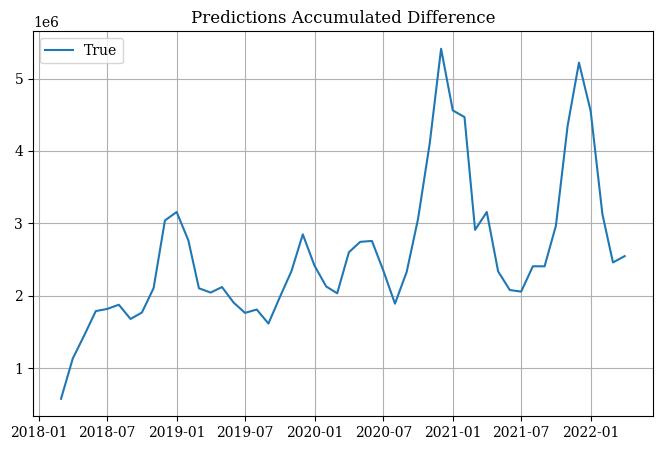

In [64]:
hplt = HierarchicalPlot(S=S_df, tags=tags)

hplt.plot_hierarchical_predictions_gap(Y_df=Y_train_df)

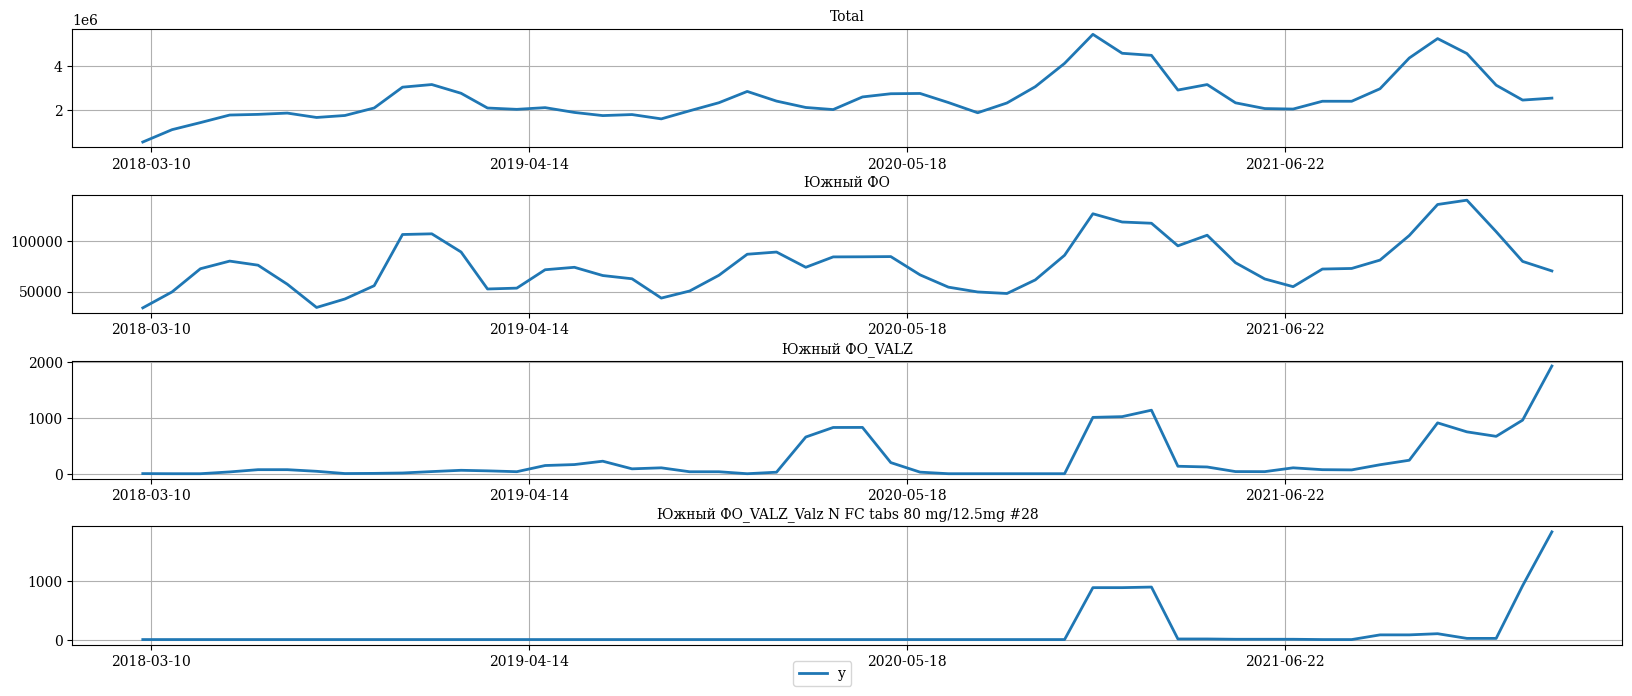

In [69]:
hplt.plot_hierarchically_linked_series(bottom_series='Южный ФО_VALZ_Valz N FC tabs 80 mg/12.5mg #28', Y_df=Y_train_df)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition:
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Wickramasuriya, S. L., Athanasopoulos, G., & Hyndman, R. J. (2019). \"Optimal forecast reconciliation for
    hierarchical and grouped time series through trace minimization\". Journal of the American Statistical Association,
    114 , 804–819. doi:10.1080/01621459.2018.1448825.](https://robjhyndman.com/publications/mint/).
- [Wickramasuriya, S.L., Turlach, B.A. & Hyndman, R.J. (2020). \"Optimal non-negative
    forecast reconciliation". Stat Comput 30, 1167–1182,
    https://doi.org/10.1007/s11222-020-09930-0](https://robjhyndman.com/publications/nnmint/).